# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

In [1]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution, easy_datetime_distribution
from bw_temporalis.lcia.climate import characterize_methane, characterize_co2
import sys
import os
sys.path.append(os.path.realpath('../'))
from medusa.edge_extractor import *
from medusa.matrix_modifier import MatrixModifier
from medusa.medusa_lca import *
from medusa.timeline_builder import TimelineBuilder
from medusa.dynamic_characterization import DynamicCharacterization
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

In [2]:
from tests.databases import *
db_dynamic_cf_test()

100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 4006.02it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]

Vacuuming database 


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 


In [3]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

# Static LCA

In [4]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 901.0


# `MEDUSA` LCA

In [5]:
SKIPPABLE = [node.id for node in bd.Database('background_2020')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Now we can do the graph traversal and create a timeline of edges:

In [6]:
import warnings
warnings.filterwarnings("ignore")

database_date_dict = {
            'background_2008': datetime.strptime("2008", "%Y"),
            'background_2024': datetime.strptime("2024", "%Y"),
            'foreground': "dynamic", # flag databases that should be temporally distributed with "dynamic"
        }

In [7]:
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)

Starting graph traversal
Calculation count: 3


In [8]:
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,1999,545,1999-01-01,539,C,1999,546,1999-01-01,543,B,13.0,{'background_2008': 1}
1,1999,546,1999-01-01,543,B,2024,548,2024-01-01,544,A,2.0,{'background_2008': 1}
2,2024,539,2024-01-01,539,C,2024,547,2024-01-01,543,B,13.0,{'background_2024': 1}
3,2024,547,2024-01-01,543,B,2024,548,2024-01-01,544,A,0.8,{'background_2024': 1}
4,2024,548,2024-01-01,544,A,2024,-1,2024-01-01,-1,-1,1.0,{'background_2024': 1}
5,2034,549,2034-01-01,543,B,2024,548,2024-01-01,544,A,1.2,{'background_2024': 1}
6,2034,550,2034-01-01,539,C,2034,549,2034-01-01,543,B,13.0,{'background_2024': 1}


In [9]:
mlca.build_datapackage()

In [10]:
mlca.lci()

In [11]:
mlca.lcia()

In [12]:
print('New MEDUSA LCA Score:', mlca.score)
print('Old static LCA Score:', slca.score)

New MEDUSA LCA Score: 901.0
Old static LCA Score: 901.0


In [13]:
mlca.build_dynamic_biosphere()

In [14]:
mlca.calculate_dynamic_lci()

In [15]:
def characterize_methane1(series, period: int = 100, cumulative=False) -> pd.DataFrame:
    """
    Calculate the cumulative or marginal radiative forcing (CRF) from CH4 for each year in a given period.

    If `cumulative` is True, the cumulative CRF is calculated. If `cumulative` is False, the marginal CRF is calculated.
    Takes a single row of the TimeSeries Pandas DataFrame (corresponding to a set of (`date`/`amount`/`flow`/`activity`).
    For earch year in the given period, the CRF is calculated.
    Units are watts/square meter/kilogram of CH4.

    Parameters
    ----------
    series : array-like
        A single row of the TimeSeries dataframe.
    period : int, optional
        Time period for calculation (number of years), by default 100
    cumulative : bool, optional
        Should the RF amounts be summed over time?

    Returns
    -------
    A TimeSeries dataframe with the following columns:
    - date: datetime64[s]
    - amount: float
    - flow: str
    - activity: str

    Notes
    -----
    See also the relevant scientific publication on CRF: https://doi.org/10.5194/acp-13-2793-2013
    See also the relevant scientific publication on the numerical calculation of CRF: http://pubs.acs.org/doi/abs/10.1021/acs.est.5b01118

    See Also
    --------
    characterize_co2: The same function for CO2
    """

    # functional variables and units (from publications listed in docstring)
    f1 = 0.5  # Unitless
    f2 = 0.15  # Unitless
    alpha = 1.27e-13  # Radiative forcing (W/m2/kg)
    tau = 12.4  # Lifetime (years)

    date_beginning: np.datetime64 = series["date"].to_numpy()
    date_characterized: np.ndarray = date_beginning + np.arange(
        start=0, stop=period, dtype="timedelta64[Y]"
    ).astype("timedelta64[s]")

    decay_multipliers: list = np.array(
        [
            (1 + f1 + f2) * alpha * tau * (1 - np.exp(-year / tau))
            for year in range(period)
        ]
    )

    forcing = pd.Series(data=series.amount * decay_multipliers, dtype="float64")
    if not cumulative:
        forcing = forcing.diff(periods=1).fillna(0)

    return pd.DataFrame(
        {
            "date": pd.Series(data=date_characterized, dtype="datetime64[s]"),
            "amount": forcing,
            "flow": series.flow,
            "activity": series.activity,
        }
    )


In [40]:
def characterize_n2o(n2o_decay_array, series, period: int = 100, cumulative=False) -> pd.DataFrame:
    """
    
    Radiative forcing functions of N2O are taken from Levasseur et al 2010

    Units are watts/square meter/kilogram of ghg emissions

    Parameters
    ----------
    n20_decay_array:
    series : array-like
        A single row of the TimeSeries dataframe.
    period : int, optional
        Time period for calculation (number of years), by default 100
    cumulative : bool, optional
        Should the RF amounts be summed over time?

    Returns
    -------
    A TimeSeries dataframe with the following columns:
    - date: datetime64[s]
    - amount: float
    - flow: str
    - activity: str

    """

    # functional variables and units (from publications listed in docstring)
    f1 = 0.5  # Unitless
    f2 = 0.15  # Unitless
    alpha = 1.27e-13  # Radiative forcing (W/m2/kg)
    tau = 12.4  # Lifetime (years)
    
    date_beginning: np.datetime64 = series["date"].to_numpy()
    date_characterized: np.ndarray = date_beginning + np.arange(
        start=0, stop=period, dtype="timedelta64[Y]"
    ).astype("timedelta64[s]")

    decay_multipliers: list = np.array(
        [
            (1 + f1 + f2) * alpha * tau * (1 - np.exp(-year / tau))
            for year in range(period)
        ]
    )
    print(decay_multipliers[0:10])
    print(len(decay_multipliers))
    print(n2o_decay_array)
    decay_multiplier_y0 = [0] #no forcing in y0
    decay_multipliers_year1to99= [n2o_decay_array[key] for key in range(1,period) if key in n2o_decay_array]
    decay_multipliers_2 = decay_multiplier_y0 + decay_multipliers_year1to99
    decay_multipliers_2= np.cumsum(decay_multipliers_2)
    print("-------------------")
    print(decay_multipliers_2[0:10])
    print(len(decay_multipliers_2))
    print(len(date_characterized))
    # forcing = pd.Series(data=series.amount * decay_multipliers, dtype="float64")
    # if not cumulative:
    #     forcing = forcing.diff(periods=1).fillna(0)
    forcing2 = pd.Series(data=series.amount * decay_multipliers_2, dtype="float64")
    if not cumulative:
        forcing2 = forcing2.diff(periods=1).fillna(0)

    return pd.DataFrame(
        {
            "date": pd.Series(data=date_characterized, dtype="datetime64[s]"),
            # "amount": forcing,
            "amount_levasseur": forcing2,
            # "delta[%]" :(forcing2-forcing)/forcing2*100,
            "flow": series.flow,
            "activity": series.activity,
        }
    )


In [17]:
period = 100
#range(period+1)
print(len(range(period+1)))

101


In [18]:
#Levasseur
import pandas as pd

# Read the Excel file
excel_file = 'Dynamic_LCAcalculatorv.2.0.xlsm'
sheet_name = 'FC'
data = pd.read_excel(excel_file, sheet_name=sheet_name)


data = data.iloc[2:] #Remove the first three empty rows
data.columns = data.iloc[0] # Set the first row as the header
data = data.iloc[3:,:] #remove row 0-2 (contain units)
data = data.rename(columns={data.columns[0]: 'year'}) # replace the first column label (NaN) with 'Year'
data = data.sort_values('year') #sort by year

# Convert DataFrame to dictionary
levasseur_radiative_forcing = {}
for column in data.columns:
    levasseur_radiative_forcing[column] = dict(zip(data.iloc[:, 0], data[column]))


In [41]:
compare_forcing = pd.concat(
                [characterize_n2o(levasseur_radiative_forcing["N2O"], row) for _, row in mlca.dynamic_inventory_characterizer.dynamic_lci_df.iterrows()] # using characterization function from bw_temporalis
            )

compare_forcing
#print("here")


[0.00000000e+00 2.01323036e-13 3.87047761e-13 5.58382716e-13
 7.16442807e-13 8.62256556e-13 9.96772799e-13 1.12086686e-12
 1.23534623e-12 1.34095585e-12]
100
{1: 3.5546788110300165e-13, 2: 3.5254223611371447e-13, 3: 3.496406703705638e-13, 4: 3.467629856915832e-13, 5: 3.4390898552591374e-13, 6: 3.410784749403935e-13, 7: 3.382712606062418e-13, 8: 3.3548715078585307e-13, 9: 3.3272595531969144e-13, 10: 3.299874856133288e-13, 11: 3.272715546245258e-13, 12: 3.245779768504875e-13, 13: 3.21906568315182e-13, 14: 3.192571465567736e-13, 15: 3.166295306151619e-13, 16: 3.140235410196179e-13, 17: 3.1143899977653155e-13, 18: 3.0887573035726376e-13, 19: 3.0633355768605754e-13, 20: 3.038123081281132e-13, 21: 3.013118094777128e-13, 22: 2.988318909464603e-13, 23: 2.96372383151631e-13, 24: 2.9393311810455676e-13, 25: 2.91513929199221e-13, 26: 2.891146512008189e-13, 27: 2.867351202345083e-13, 28: 2.8437517377418294e-13, 29: 2.8203465063142373e-13, 30: 2.7971339094443446e-13, 31: 2.774112361671463e-13, 32: 

,date,amount_levasseur,flow,activity
0,1988-01-01 03:36:00,0.000000e+00,537,542
1,1988-12-31 09:25:12,3.116473e-11,537,542
2,1989-12-31 15:14:24,3.090824e-11,537,542
3,1990-12-31 21:03:36,3.065385e-11,537,542
4,1992-01-01 02:52:48,3.040155e-11,537,542
...,...,...,...,...
95,2127-01-01 13:15:36,1.945390e-13,538,549
96,2128-01-01 19:04:48,1.929378e-13,538,549
97,2129-01-01 00:54:00,1.913499e-13,538,549
98,2130-01-01 06:43:12,1.897750e-13,538,549


In [24]:
for _, row in mlca.dynamic_inventory_characterizer.dynamic_lci_df.iterrows():
    print(row["date"])

1988-01-01 03:36:00
1999-01-01 00:00:00
2004-01-01 03:36:00
2008-01-01 00:00:00
2008-01-01 00:00:00
2017-12-31 10:12:00
2022-12-31 18:10:48
2024-01-01 00:00:00
2024-01-01 00:00:00
2027-12-31 20:24:00
2033-12-31 10:12:00
2034-01-01 00:00:00
2043-12-31 20:24:00
1996-12-31 12:21:36
2021-12-31 12:21:36
2032-01-01 12:21:36


In [ ]:
characterized_inventory[50:200]

,date,amount,amount2,delta[%],flow,activity
50,2037-12-31 06:36:00,3.421228e-13,5.361347e-13,36.187148,529,534
51,2038-12-31 12:25:12,3.156155e-13,5.105271e-13,38.178502,529,534
52,2039-12-31 18:14:24,2.911619e-13,4.868257e-13,40.191748,529,534
53,2040-12-31 00:03:36,2.686030e-13,4.648844e-13,42.221557,529,534
54,2041-12-31 05:52:48,2.477919e-13,4.445686e-13,44.262400,529,534
...,...,...,...,...,...,...
95,2093-12-31 00:54:00,4.540288e-14,9.559097e-13,95.250296,529,537
96,2094-12-31 06:43:12,4.188511e-14,9.499482e-13,95.590801,529,537
97,2095-12-31 12:32:24,3.863989e-14,9.442856e-13,95.908029,529,537
98,2096-12-30 18:21:36,3.564611e-14,9.389015e-13,96.203424,529,537


,date,amount,amount2,flow,activity
0,1988-01-01 03:36:00,0.000000e+00,0.000000e+00,529,534
1,1988-12-31 09:25:12,1.779696e-11,1.404390e-13,529,534
2,1989-12-31 15:14:24,1.641807e-11,1.329441e-13,529,534
3,1990-12-31 21:03:36,1.514601e-11,1.267809e-13,529,534
4,1992-01-01 02:52:48,1.397251e-11,1.216787e-13,529,534
...,...,...,...,...,...
95,2127-01-01 13:15:36,1.232657e-16,8.698677e-16,530,541
96,2128-01-01 19:04:48,1.137152e-16,8.677576e-16,530,541
97,2129-01-01 00:54:00,1.049047e-16,8.656814e-16,530,541
98,2130-01-01 06:43:12,9.677677e-17,8.636386e-16,530,541


In [ ]:
def characterize_co21(
    series,
    period: int | None = 100,
    cumulative: bool | None = False,
) -> pd.DataFrame:
    """
    Calculate the cumulative or marginal radiative forcing (CRF) from CO2 for each year in a given period.

    If `cumulative` is True, the cumulative CRF is calculated. If `cumulative` is False, the marginal CRF is calculated.
    Takes a single row of the TimeSeries Pandas DataFrame (corresponding to a set of (`date`/`amount`/`flow`/`activity`).
    For each year in the given period, the CRF is calculated.
    Units are watts/square meter/kilogram of CO2.

    Returns
    -------
    A TimeSeries dataframe with the following columns:
    - date: datetime64[s]
    - amount: float
    - flow: str
    - activity: str

    Notes
    -----
    See also the relevant scientific publication on CRF: https://doi.org/10.5194/acp-13-2793-2013
    See also the relevant scientific publication on the numerical calculation of CRF: http://pubs.acs.org/doi/abs/10.1021/acs.est.5b01118

    See Also
    --------
    characterize_methane: The same function for CH4
    """

    # functional variables and units (from publications listed in docstring)
    RE = 1.76e-15  # Radiative forcing (W/m2/kg)
    alpha_0, alpha_1, alpha_2, alpha_3 = 0.2173, 0.2240, 0.2824, 0.2763
    tau_1, tau_2, tau_3 = 394.4, 36.54, 4.304
    decay_term = lambda year, alpha, tau: alpha * tau * (1 - np.exp(-year / tau))

    date_beginning: np.datetime64 = series["date"].to_numpy()
    date_characterized: np.ndarray = date_beginning + np.arange(
        start=0, stop=period, dtype="timedelta64[Y]"
    ).astype("timedelta64[s]")

    decay_multipliers: np.ndarray = np.array(
        [
            RE
            * (
                alpha_0 * year
                + decay_term(year, alpha_1, tau_1)
                + decay_term(year, alpha_2, tau_2)
                + decay_term(year, alpha_3, tau_3)
            )
            for year in range(period)
        ]
    )

    forcing = pd.Series(data=series.amount * decay_multipliers, dtype="float64")
    if not cumulative:
        forcing = forcing.diff(periods=1).fillna(0)

    return pd.DataFrame(
        {
            "date": pd.Series(data=date_characterized, dtype="datetime64[s]"),
            "amount": forcing,
            "flow": series.flow,
            "activity": series.activity,
        }
    )

In [20]:
mlca.characterize_dynamic_lci({"carbon dioxide": characterize_co2, "methane": characterize_methane})	


In [ ]:
mlca.characterized_inventory

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,1988-01-01 03:36:00,0.000000e+00,529,carbon dioxide,534,"(background_2008, electricity_wind)",0.000000e+00
1,1988-12-31 09:25:12,1.503154e-13,529,carbon dioxide,534,"(background_2008, electricity_wind)",1.503154e-13
2,1989-12-31 15:14:24,1.411044e-13,529,carbon dioxide,534,"(background_2008, electricity_wind)",2.914199e-13
3,1990-12-31 21:03:36,1.335741e-13,529,carbon dioxide,534,"(background_2008, electricity_wind)",4.249939e-13
4,1992-01-01 02:52:48,1.273816e-13,529,carbon dioxide,534,"(background_2008, electricity_wind)",5.523755e-13
...,...,...,...,...,...,...,...
1595,2127-01-01 13:15:36,1.232657e-16,530,methane,541,"(foreground, B)",1.038973e-11
1596,2128-01-01 19:04:48,1.137152e-16,530,methane,541,"(foreground, B)",1.038985e-11
1597,2129-01-01 00:54:00,1.049047e-16,530,methane,541,"(foreground, B)",1.038995e-11
1598,2130-01-01 06:43:12,9.677677e-17,530,methane,541,"(foreground, B)",1.039005e-11


In [21]:
df =mlca.dynamic_inventory_characterizer.dynamic_lci_df

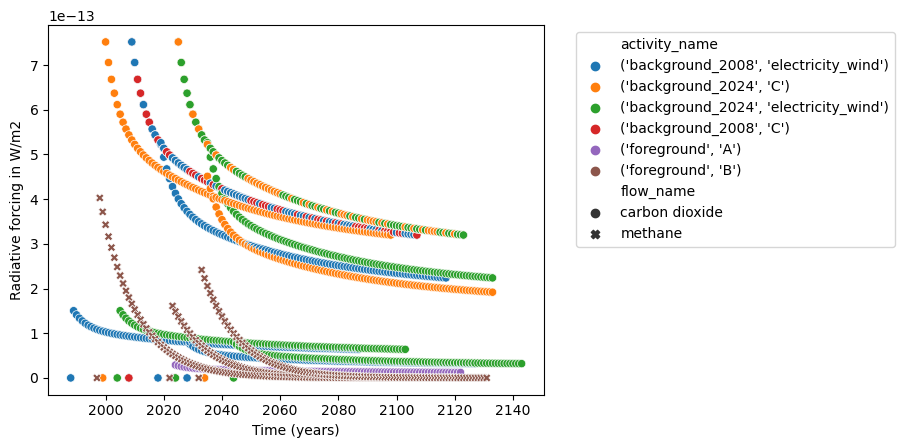

In [ ]:
mlca.plot_dynamic_characterized_inventory()

In [ ]:
mlca.dynamic_inventory_characterizer.dynamic_characterization_from_giuseppe_levasseur(mlca.characterized_inventory,cumulative=False )

test


In [ ]:
def characterize_methane(series, period: int = 100, cumulative=False) -> pd.DataFrame:
    """
    Calculate the cumulative or marginal radiative forcing (CRF) from CH4 for each year in a given period.

    If `cumulative` is True, the cumulative CRF is calculated. If `cumulative` is False, the marginal CRF is calculated.
    Takes a single row of the TimeSeries Pandas DataFrame (corresponding to a set of (`date`/`amount`/`flow`/`activity`).
    For earch year in the given period, the CRF is calculated.
    Units are watts/square meter/kilogram of CH4.

    Parameters
    ----------
    series : array-like
        A single row of the TimeSeries dataframe.
    period : int, optional
        Time period for calculation (number of years), by default 100
    cumulative : bool, optional
        Should the RF amounts be summed over time?

    Returns
    -------
    A TimeSeries dataframe with the following columns:
    - date: datetime64[s]
    - amount: float
    - flow: str
    - activity: str

    Notes
    -----
    See also the relevant scientific publication on CRF: https://doi.org/10.5194/acp-13-2793-2013
    See also the relevant scientific publication on the numerical calculation of CRF: http://pubs.acs.org/doi/abs/10.1021/acs.est.5b01118

    See Also
    --------
    characterize_co2: The same function for CO2
    """

    # functional variables and units (from publications listed in docstring)
    f1 = 0.5  # Unitless
    f2 = 0.15  # Unitless
    alpha = 1.27e-13  # Radiative forcing (W/m2/kg)
    tau = 12.4  # Lifetime (years)

    date_beginning: np.datetime64 = series["date"].to_numpy()
    date_characterized: np.ndarray = date_beginning + np.arange(
        start=0, stop=period, dtype="timedelta64[Y]"
    ).astype("timedelta64[s]")

    decay_multipliers: list = np.array(
        [
            (1 + f1 + f2) * alpha * tau * (1 - np.exp(-year / tau))
            for year in range(period)
        ]
    )

    forcing = pd.Series(data=series.amount * decay_multipliers, dtype="float64")
    if not cumulative:
        forcing = forcing.diff(periods=1).fillna(0)

    return pd.DataFrame(
        {
            "date": pd.Series(data=date_characterized, dtype="datetime64[s]"),
            "amount": forcing,
            "flow": series.flow,
            "activity": series.activity,
        }
    )


TODO make sure all arguments can be passed, e.g. cumsum. switch between methane and CO2,
 addition of methane and CO2, selected timeframe, add units, add ids sum needs to be the same as for temporalis example

Last progress dynamic cf:
got decay curves from G. 
 use these and the other olde code snips to implement dynamic characterization in medusa: think strategic and from output to output -> define framework of methods: what do they take in, what do they give back and then use snippets of G. code